# Example: RDF workflow

This notebook demonstrates the usage of the [rdf.py](../src/pyBiodatafuse/graph/rdf.py) module.

In [1]:
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "src")))
import pandas as pd
from pyBiodatafuse.graph import rdf
from shexer.shaper import Shaper
from shexer.consts import NT, SHEXC, SHACL_TURTLE

### Load the sample property table

In [2]:
data = pd.read_pickle("../examples/usecases/PCS/combined_df.pkl")
metadata = pd.read_pickle("../examples/usecases/PCS/combined_metadata.pkl")
data.head(3)

,identifier,identifier.source,target,target.source,DISGENET_diseases,literature_based_info,OpenTargets_gene_compounds,MINERVA,WikiPathways,OpenTargets_reactome,OpenTargets_go,StringDB_ppi
0,DMP1,HGNC,ENSG00000152592,Ensembl,"[{'disease_name': 'Hypophosphatemic Rickets', ...","[{'disease_name': 'Post-COVID-19', 'id': 'C000...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': 'WP3971', 'pathway_label': 'OS...","[{'pathway_label': 'ECM proteoglycans', 'pathw...","[{'go_id': 'GO:0005788', 'go_name': 'endoplasm...","[{'stringdb_link_to': 'TNFRSF11B', 'Ensembl': ..."
1,PNLIP,HGNC,ENSG00000175535,Ensembl,[{'disease_name': 'Pancreatic Lipase Deficienc...,"[{'disease_name': nan, 'id': nan, 'source': nan}]","[{'chembl_id': 'CHEMBL175247', 'drugbank_id': ...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Retinoid metabolism and tr...,"[{'go_id': 'GO:0004806', 'go_name': 'triglycer...","[{'stringdb_link_to': 'LIPE', 'Ensembl': 'ENSP..."
2,OR4N3P,HGNC,ENSG00000259435,Ensembl,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'id': nan, 'source': nan}]","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_label': nan, 'pathway_id': nan}]","[{'go_id': nan, 'go_name': nan, 'go_type': nan}]","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."


In [3]:
print(len(data))
data.describe()

2421


,identifier,identifier.source,target,target.source,DISGENET_diseases,literature_based_info,OpenTargets_gene_compounds,MINERVA,WikiPathways,OpenTargets_reactome,OpenTargets_go,StringDB_ppi
count,2421,2421,2421,2421,2329,2329,2421,2421,2329,2421,2421,2421
unique,1667,1,1675,1,1560,1566,1675,1596,1461,1447,1637,1667
top,TEKT4P2,HGNC,ENSG00000188681,Ensembl,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'id': nan, 'source': nan}]","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_label': nan, 'pathway_id': nan}]","[{'go_id': nan, 'go_name': nan, 'go_type': nan}]","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
freq,256,2421,128,2421,128,128,128,128,128,128,128,128


### Generating RDF from table


The function to generate an RDF `rdflib` graph (`generate_rdf()`) takes arguments:


In [4]:
g = rdf.generate_rdf(df = data, 
                     base_uri = "https://biodatafuse.org/example/", 
                     version_iri = "https://biodatafuse.org/example/test.owl", 
                     orcid = "https://orcid.org/0000-0002-4166-7093", 
                     author="Javier Millan Acosta", 
                     metadata = metadata)

### Print out result

In [5]:
ttl = g.serialize(format="turtle", destination='pcs_graph.ttl')

## Querying the graph

This section shows some competency questions around the PCS case.

### Q1
> what are the genes from the publication [literature_disease_attrs["id"] = "C00000"] in covid19 map pathways in minerva https://pubmed.ncbi.nlm.nih.gov/37675861
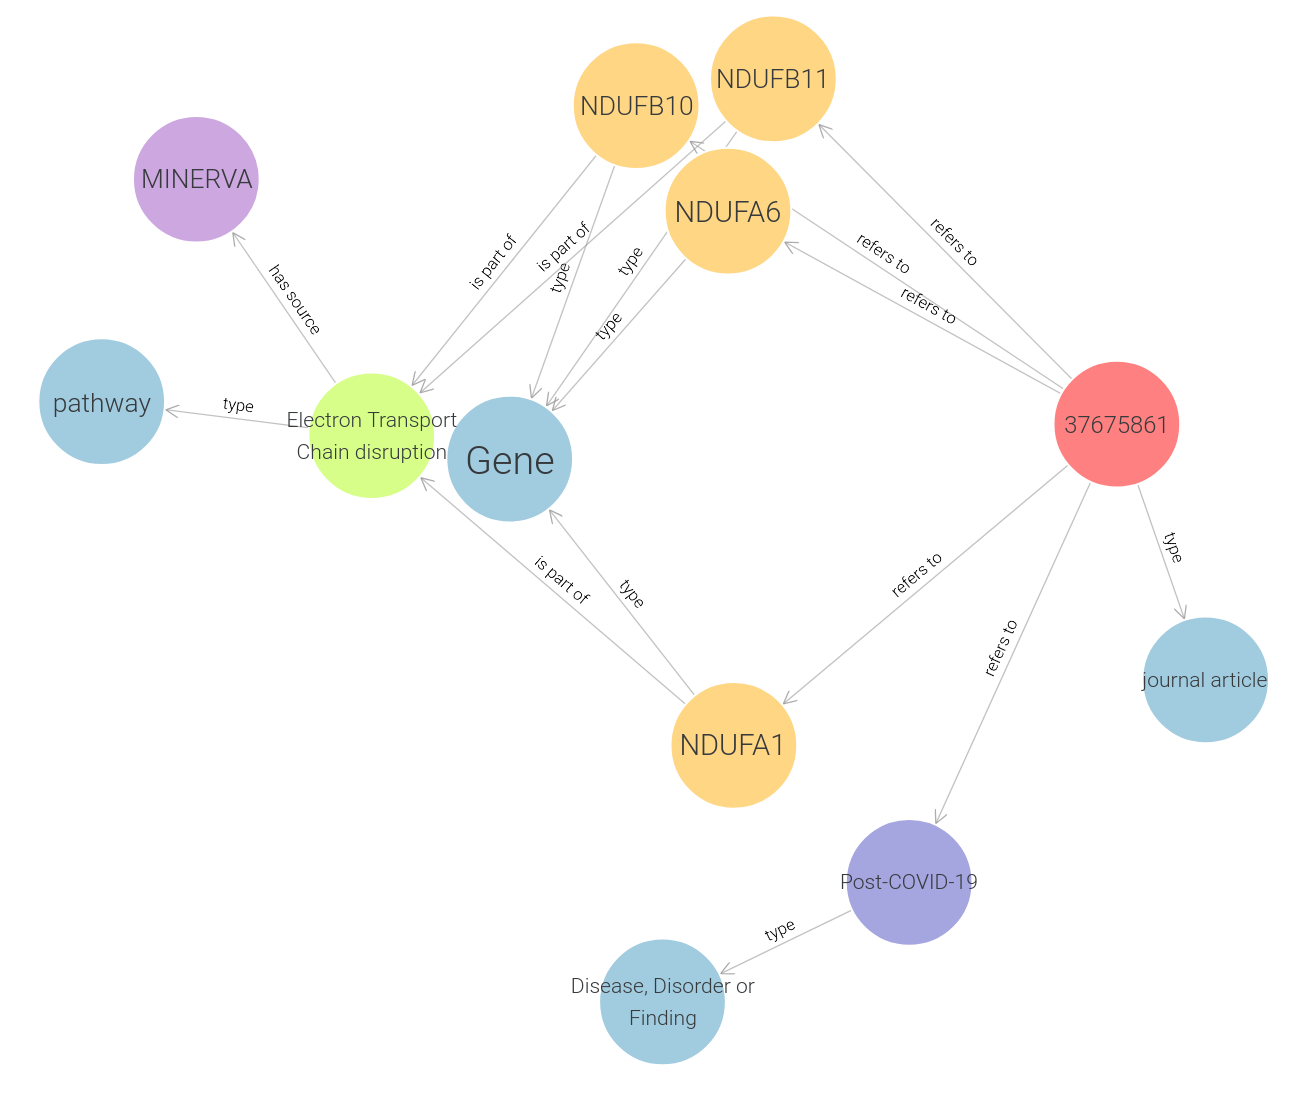

In [6]:
construct_1 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

CONSTRUCT {
    ?publication a obo:IAO_0000013 .
    ?publication sio:SIO_000628 ?gene ;
                sio:SIO_000628 ?disease .
    ?disease a obo:NCIT_C7057 .
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?pw ;
          rdfs:label ?geneLabel .
    ?pw a obo:PW_0000001 ;
        sio:SIO_000253 ?source .
}

WHERE {
    ?publication a obo:IAO_0000013 .
    ?publication sio:SIO_000628 ?gene ;
                sio:SIO_000628 ?disease .
    ?disease a obo:NCIT_C7057 .
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?pw ;
          rdfs:label ?geneLabel .
    ?pw a obo:PW_0000001 ;
        sio:SIO_000253 ?source .
    FILTER(CONTAINS(LCASE(STR(?source)), "minerva"))
}
"""

In [6]:
select_1 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT ?gene ?geneLabel
WHERE {
    ?publication a obo:IAO_0000013 ;
                 sio:SIO_000628 ?gene ;
                 sio:SIO_000628 ?disease .
                 
    ?disease a obo:NCIT_C7057 . #missing bdf identifier for specific disease
    
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?pw ;
          rdfs:label ?geneLabel .
    
    ?pw a obo:PW_0000001 ;
        sio:SIO_000253 ?source .

    FILTER(CONTAINS(LCASE(STR(?source)), "minerva"))
}
"""

### Q2
> what genes are targeted by a compound in the clinical stage 4 or approved compound for use and what is the cellular component of those genes?
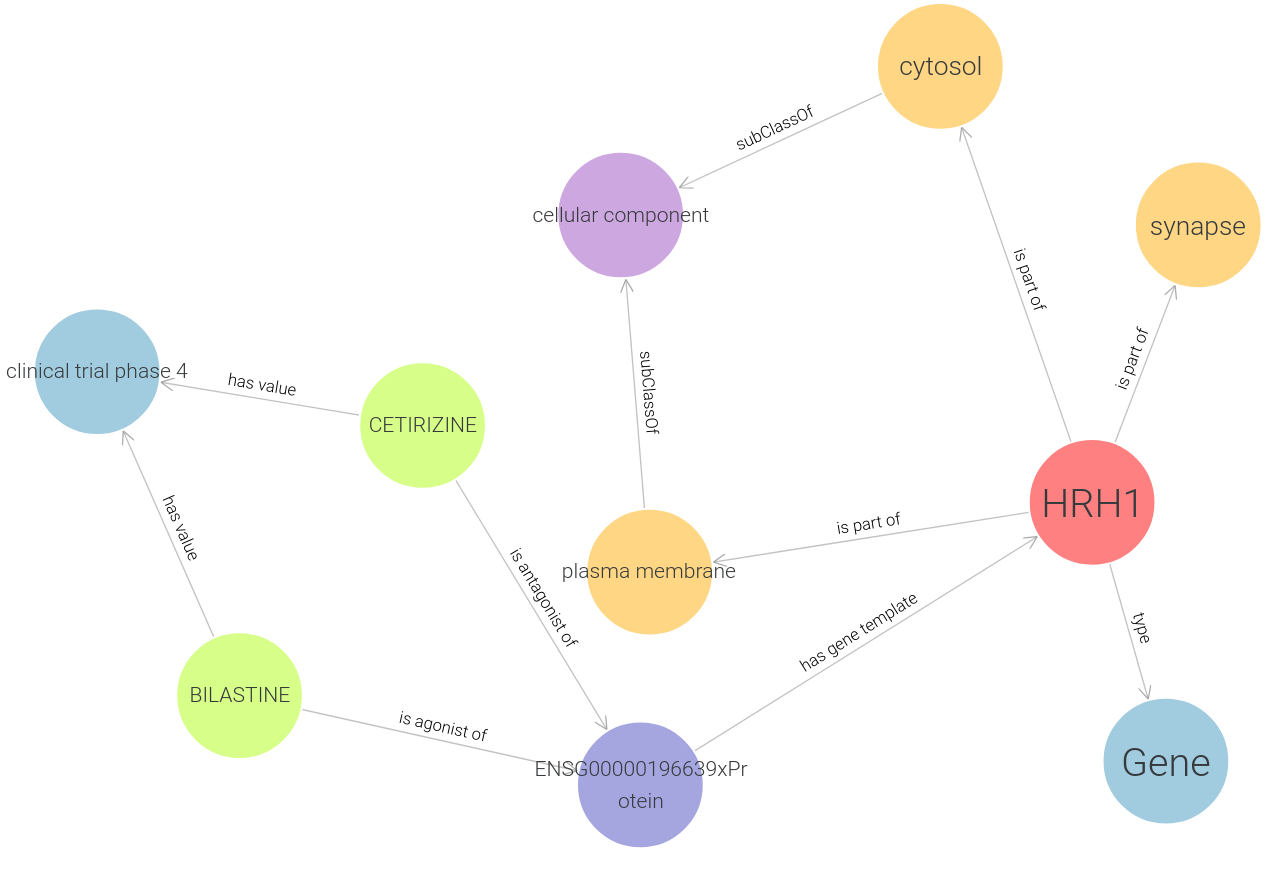

In [7]:
construct_2 = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

CONSTRUCT {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?compartment ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .

    ?agonistDrug rdfs:label ?agonistLabel ;
                 obo:RO_0018027 ?protein ;
                 rdfs:comment "agonist" ;
    			sio:SIO_000300 ?clinicalStatusAgonist .

    ?antagonistDrug rdfs:label ?antagonistLabel ;
                    obo:RO_0018029 ?protein ;
                    rdfs:comment "antagonist" ;
    			sio:SIO_000300 ?clinicalStatusAntagonist .

    ?compartment rdfs:label ?compartmentLabel ;
                 rdfs:subClassOf obo:GO_0005575 .
    obo:GO_0005575 rdfs:label "cellular compartment" .
}

WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .

        ?gene sio:SIO_000068 ?compartment .
        ?compartment rdfs:subClassOf obo:GO_0005575 ;
                     rdfs:label ?compartmentLabel .
    
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .

    # Retrieve agonists with a unique variable for the drug

        ?agonistDrug a sio:SIO_010038 ;
                     rdfs:label ?agonistLabel ;
        			sio:SIO_000300 ?clinicalStatusAgonist ;

                     obo:RO_0018027 ?protein .


    # Retrieve antagonists with a unique variable for the drug

        ?antagonistDrug a sio:SIO_010038 ;
                        rdfs:label ?antagonistLabel ;
    					sio:SIO_000300 ?clinicalStatusAntagonist ;
                        obo:RO_0018029 ?protein .
    
}
"""

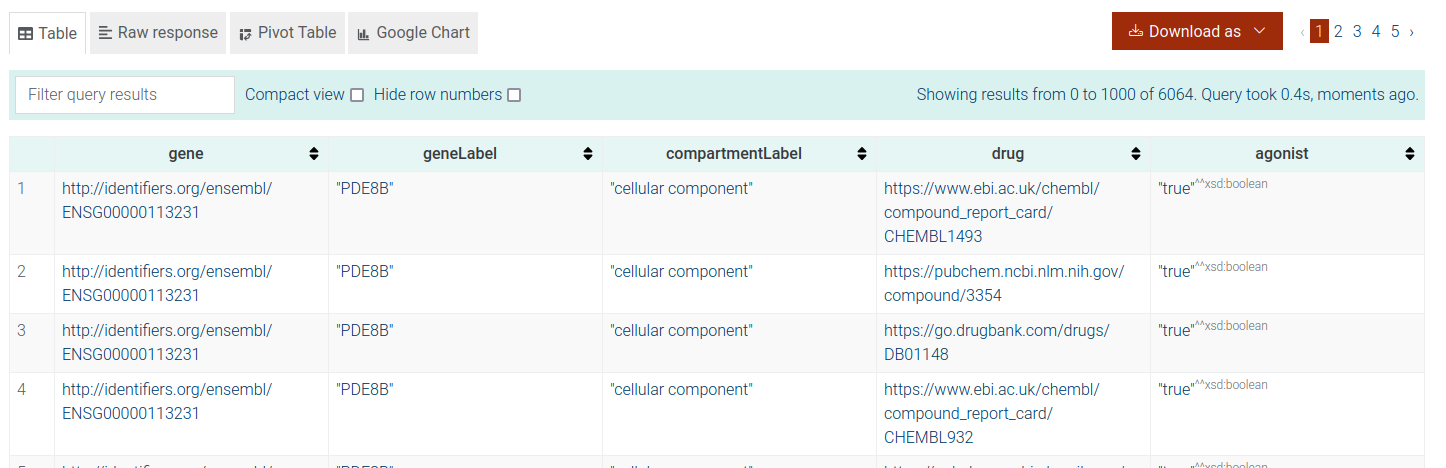

In [5]:
select_2 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT DISTINCT ?gene ?geneLabel ?compartmentLabel ?drug ?agonist
WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel ;
          sio:SIO_000068 ?compartment .
    
    ?compartment rdfs:subClassOf obo:GO_0005575 ;
                 rdfs:label ?compartmentLabel .

    ?protein pr:has_gene_template ?gene .

    # Retrieve agonist drugs targeting the protein
    {
        ?drug a sio:SIO_010038 ;
              obo:RO_0018027 ?protein ;
              sio:SIO_000300 ?clinicalStatusAgonist .
        FILTER(?clinicalStatusAgonist = obo:OPMI_0000371)
        BIND(true AS ?agonist)
    }
    UNION
    # Retrieve antagonist drugs targeting the protein with specific status
    {
        ?drug a sio:SIO_010038 ;
              obo:RO_0018029 ?protein ;
              sio:SIO_000300 obo:OPMI_0000371 .
        BIND(false AS ?agonist)
    }
}

"""

### Q3
> what genes are targeted by a compound in the clinical stage 4 or approved compound for use and what is the biological process of those genes?
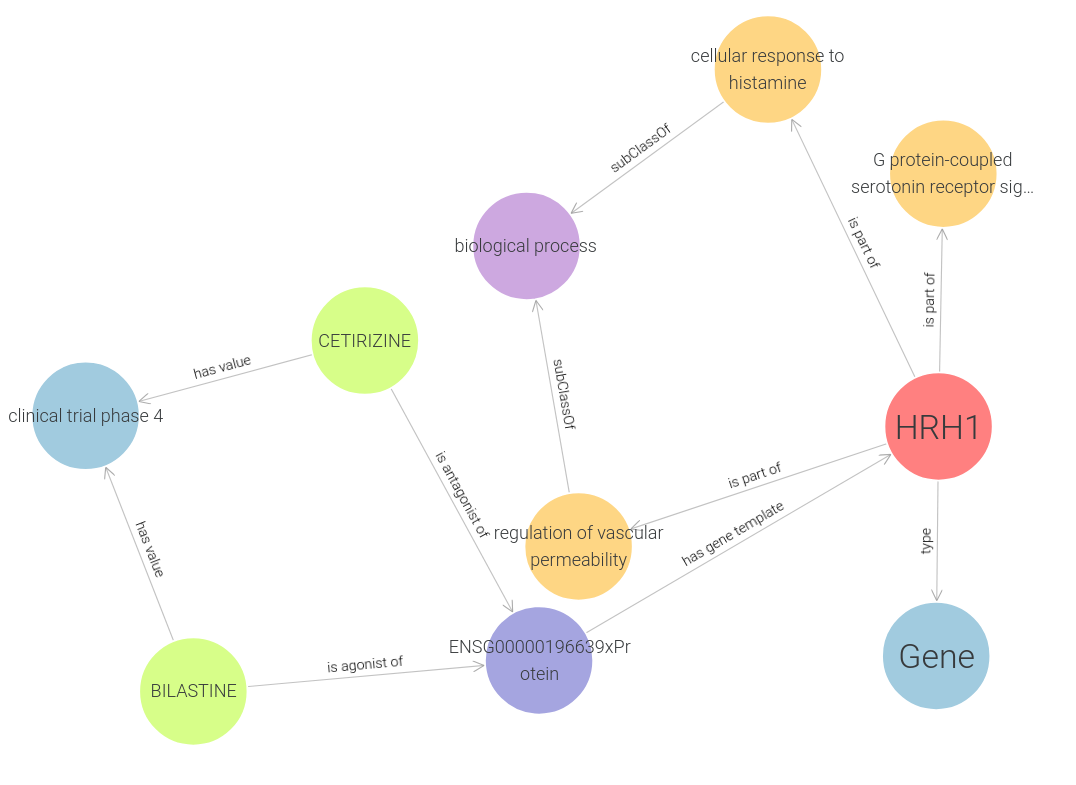

In [8]:
construct_3 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

CONSTRUCT {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?process ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .

    ?agonistDrug rdfs:label ?agonistLabel ;
                 obo:RO_0018027 ?protein ;
                 rdfs:comment "agonist" ;
    			sio:SIO_000300 ?clinicalStatusAgonist .

    ?antagonistDrug rdfs:label ?antagonistLabel ;
                    obo:RO_0018029 ?protein ;
                    rdfs:comment "antagonist" ;
    			sio:SIO_000300 ?clinicalStatusAntagonist .

    ?process rdfs:label ?processLabel ;
                 rdfs:subClassOf obo:GO_0008150 .
    obo:GO_0008150 rdfs:label "biological process" .
}

WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .

        ?gene sio:SIO_000068 ?process .
        ?process rdfs:label ?processLabel ;
                 rdfs:subClassOf obo:GO_0008150 .
    obo:GO_0008150 rdfs:label "biological process" .
    
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .

    # Retrieve agonists with a unique variable for the drug

        ?agonistDrug a sio:SIO_010038 ;
                     rdfs:label ?agonistLabel ;
        			sio:SIO_000300 ?clinicalStatusAgonist ;

                     obo:RO_0018027 ?protein .


    # Retrieve antagonists with a unique variable for the drug

        ?antagonistDrug a sio:SIO_010038 ;
                        rdfs:label ?antagonistLabel ;
    					sio:SIO_000300 ?clinicalStatusAntagonist ;
                        obo:RO_0018029 ?protein .
    
}
"""

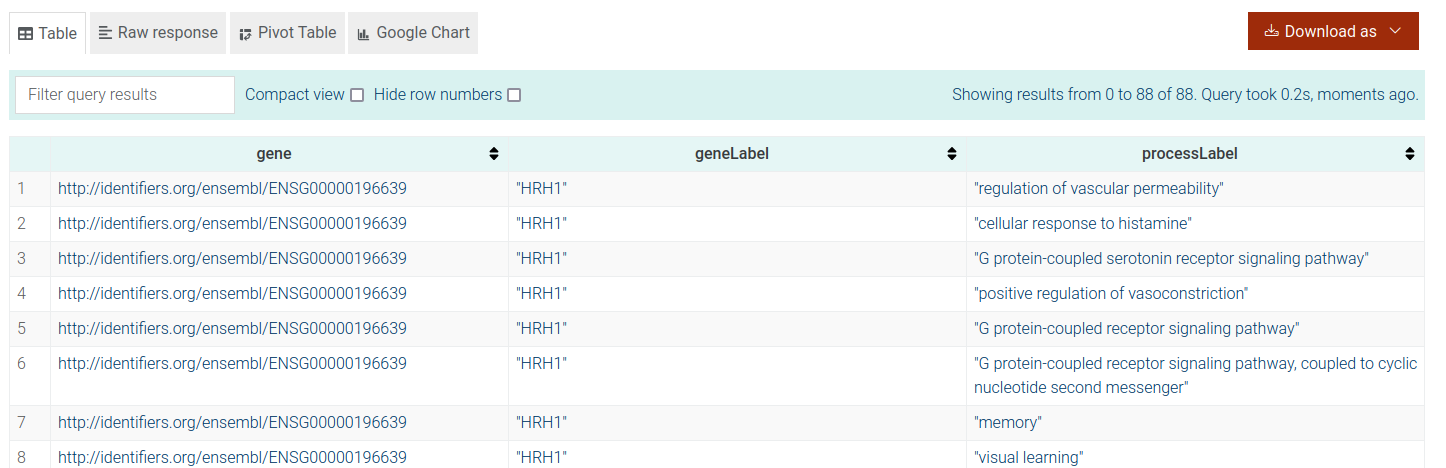

In [ ]:
select_3 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT ?gene ?geneLabel ?processLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel ;
          sio:SIO_000068 ?process .
    
    ?process rdfs:label ?processLabel ;
             rdfs:subClassOf obo:GO_0008150 .
    
    ?protein pr:has_gene_template ?gene .

    # Retrieve agonist drugs targeting the protein
    ?agonistDrug a sio:SIO_010038 ;
                 obo:RO_0018027 ?protein ;
                 sio:SIO_000300 ?clinicalStatusAgonist .

    # Retrieve antagonist drugs targeting the protein with specific status
    ?antagonistDrug a sio:SIO_010038 ;
                    obo:RO_0018029 ?protein ;
                    sio:SIO_000300 obo:OPMI_0000371 .

    # Filter for clinical status 4 or approved status for agonists
    FILTER(?clinicalStatusAgonist = obo:OPMI_0000371)
}

"""

### Q4
> what genes are targeted by a compound in the clinical stage 4 or approved compound for use and what is the molecular function of those genes?
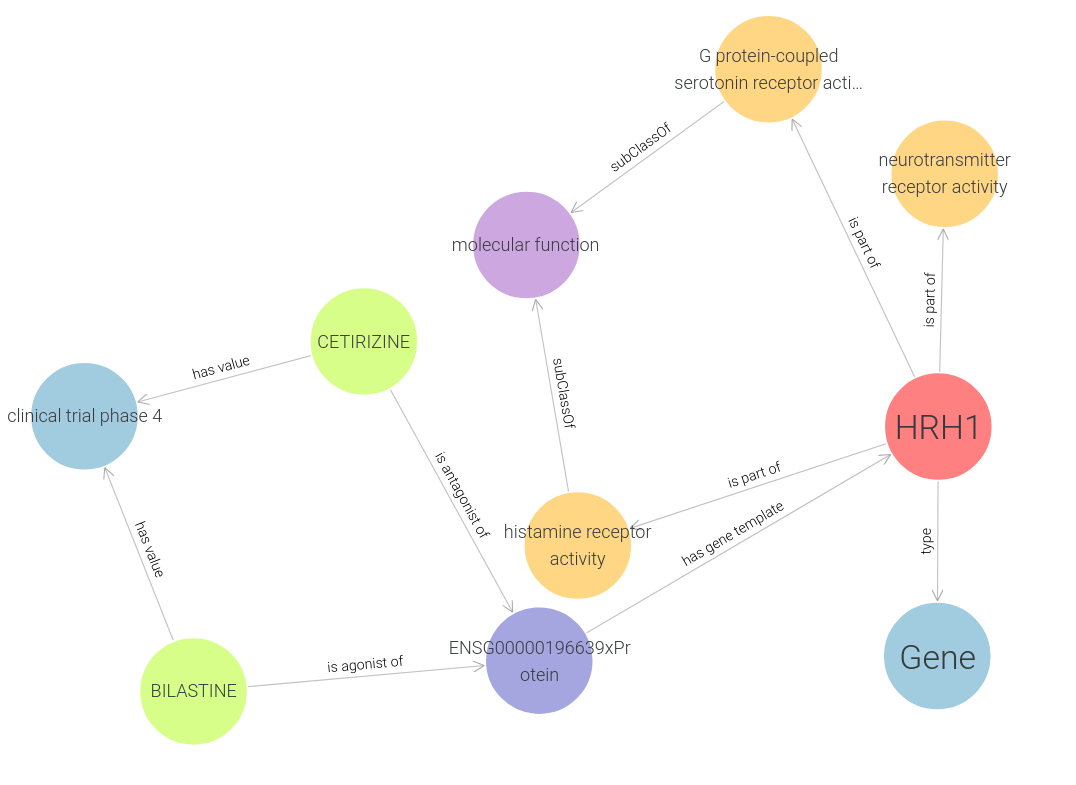

In [9]:
construct_4 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

CONSTRUCT {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?function ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .

    ?agonistDrug rdfs:label ?agonistLabel ;
                 obo:RO_0018027 ?protein ;
                 rdfs:comment "agonist" ;
    			sio:SIO_000300 ?clinicalStatusAgonist .

    ?antagonistDrug rdfs:label ?antagonistLabel ;
                    obo:RO_0018029 ?protein ;
                    rdfs:comment "antagonist" ;
    			sio:SIO_000300 ?clinicalStatusAntagonist .

    ?function rdfs:label ?functionLabel ;
                 rdfs:subClassOf obo:GO_0003674 .
    obo:GO_0003674 rdfs:label "molecular function" .
}

WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .

        ?gene sio:SIO_000068 ?function .
        ?function rdfs:label ?functionLabel ;
                 rdfs:subClassOf obo:GO_0003674 .
    obo:GO_0003674 rdfs:label "molecular function" .
    
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .

    # Retrieve agonists with a unique variable for the drug

        ?agonistDrug a sio:SIO_010038 ;
                     rdfs:label ?agonistLabel ;
        			sio:SIO_000300 ?clinicalStatusAgonist ;

                     obo:RO_0018027 ?protein .


    # Retrieve antagonists with a unique variable for the drug

        ?antagonistDrug a sio:SIO_010038 ;
                        rdfs:label ?antagonistLabel ;
    					sio:SIO_000300 ?clinicalStatusAntagonist ;
                        obo:RO_0018029 ?protein .
    
}
"""

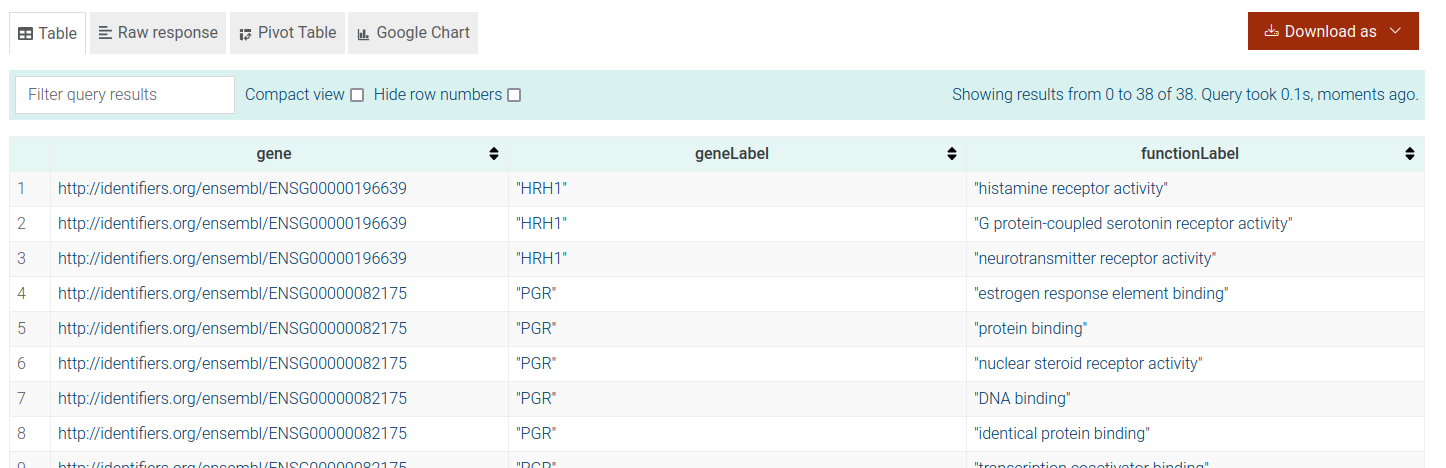

In [3]:
select_4 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT distinct ?gene ?geneLabel ?functionLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel ;
          sio:SIO_000068 ?function .
    
    ?function rdfs:label ?functionLabel ;
              rdfs:subClassOf obo:GO_0003674 .
    
    ?protein pr:has_gene_template ?gene .

    # Retrieve agonist drugs targeting the protein
    ?agonistDrug a sio:SIO_010038 ;
                 obo:RO_0018027 ?protein ;
                 sio:SIO_000300 ?clinicalStatusAgonist .

    # Retrieve antagonist drugs targeting the protein with specific status
    ?antagonistDrug a sio:SIO_010038 ;
                    obo:RO_0018029 ?protein ;
                    sio:SIO_000300 obo:OPMI_0000371 .

    # Filter for clinical status 4 or approved status for agonists
    FILTER(?clinicalStatusAgonist = obo:OPMI_0000371)
}
"""

### Q5
> Compound which targets genes with protein products that have high ppi score with other proteins (0.8) (compound and protein targeted)
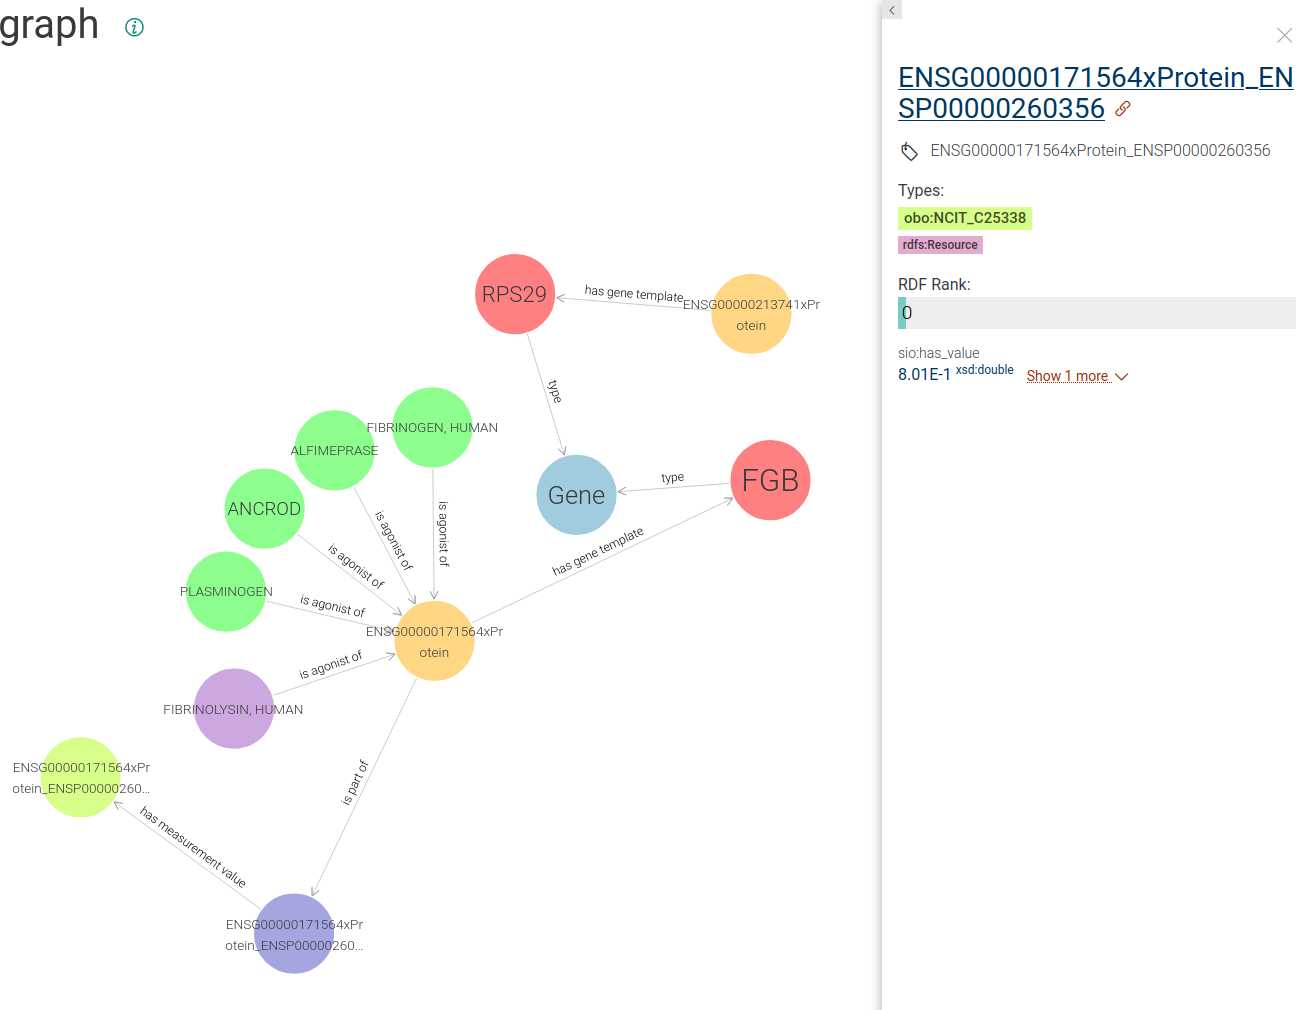

In [10]:
construct_5 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

CONSTRUCT {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi .
    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel .
}

WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi .
    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    FILTER(?scoreValue > 0.8)
    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel .
    VALUES ?predicate { obo:RO_0018027 obo:RO_0018029 }
}

"""

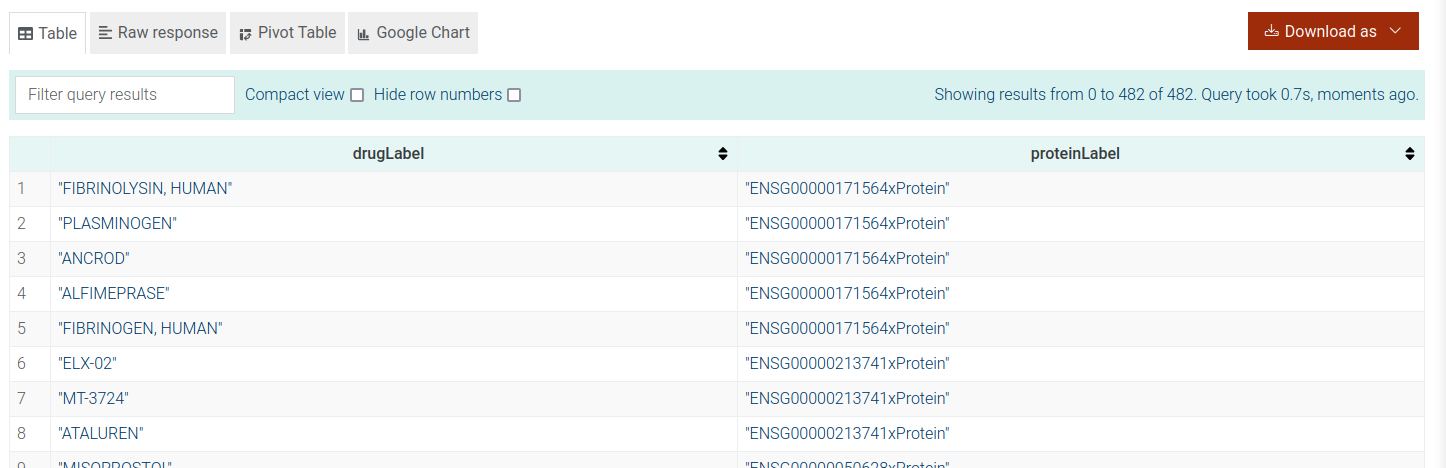

In [1]:
select_5 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT DISTINCT ?drugLabel ?proteinLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi .
    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    FILTER(?scoreValue > 0.8)

    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel .
    VALUES ?predicate { obo:RO_0018027 obo:RO_0018029 }
}

"""

### Q6 
> Pathways involving proteins targeted by drugs and participating in ppis with a score above 0.8
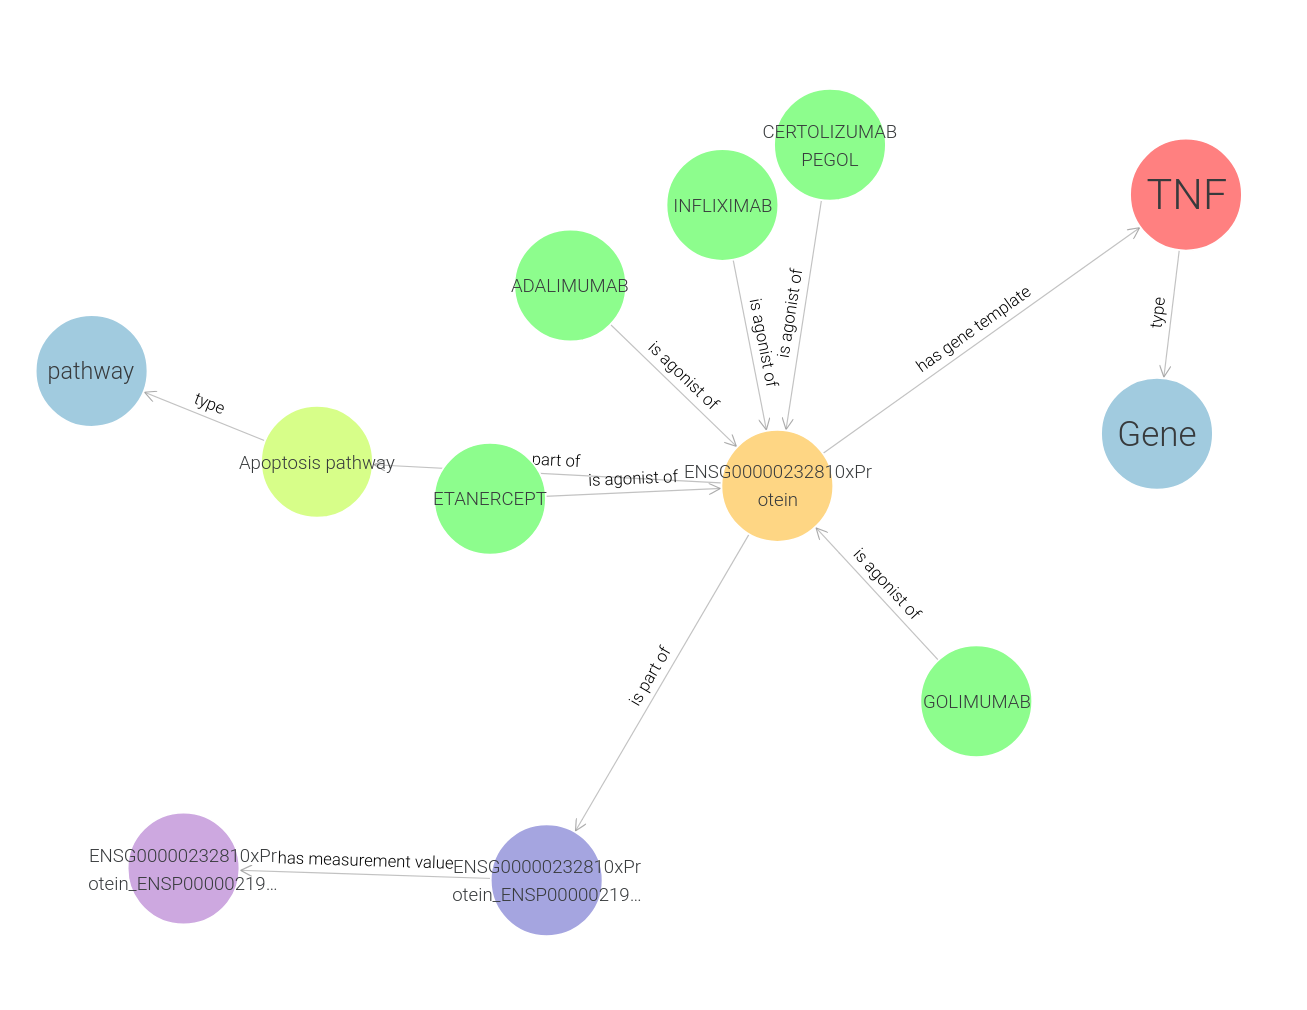

In [11]:
construct_6 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

CONSTRUCT {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi ;
             sio:SIO_000068 ?pw .
    ?pw a obo:PW_0000001 .
    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel .
}

WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi ;
             sio:SIO_000068 ?pw .
    ?pw a obo:PW_0000001 .

    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    FILTER(?scoreValue > 0.8)
    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel .
    VALUES ?predicate { obo:RO_0018027 obo:RO_0018029 }
}

"""

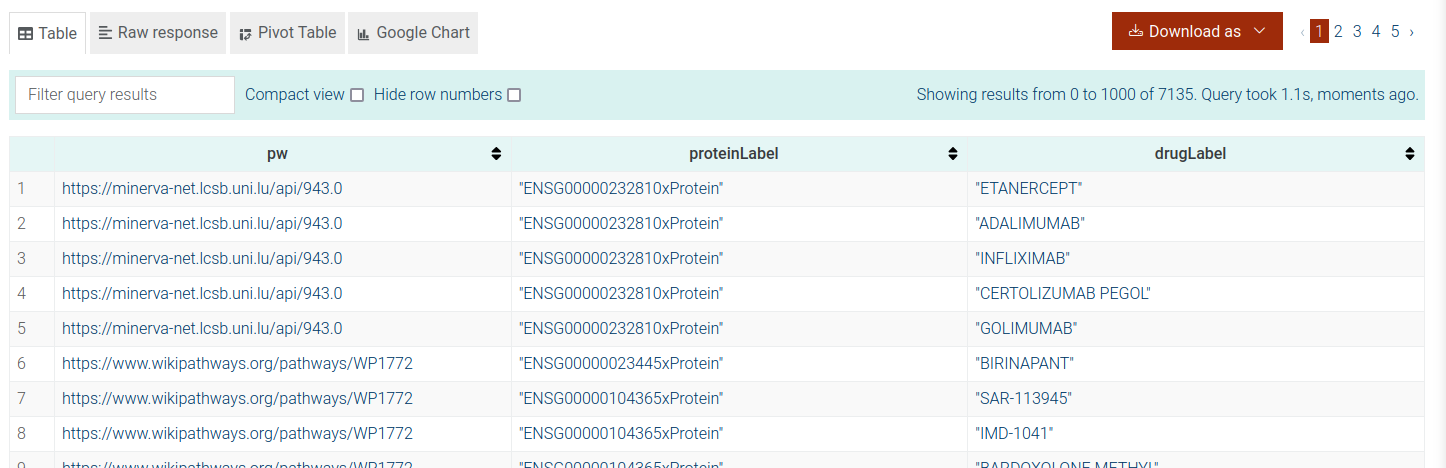

In [ ]:
select_6 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT DISTINCT ?pw ?proteinLabel ?drugLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi ;
             sio:SIO_000068 ?pw .
    ?pw a obo:PW_0000001 .

    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    FILTER(?scoreValue > 0.8)

    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel .
    VALUES ?predicate { obo:RO_0018027 obo:RO_0018029 }
}

"""

## Q7
> Compound which targets genes with protein products that have high ppi score with other proteins (0.8) (compound and protein targeted), (sort by) adverse outcome count for those compounds


In [12]:
construct_7 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

CONSTRUCT {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi .
    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel ;
    	  sio:SIO_000248 ?ae .
    ?ae rdfs:label ?aeLabel .
}

WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi .

    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    FILTER(?scoreValue > 0.8)
        ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel ;
    	  sio:SIO_000248 ?ae .
    ?ae rdfs:label ?aeLabel .
    VALUES ?predicate { obo:RO_0018027 obo:RO_0018029 }

}
"""

In [2]:
select_7 = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT DISTINCT ?drug ?drugLabel (COUNT(DISTINCT ?ae) AS ?adverseEventCount)
WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?protein pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel ;
             sio:SIO_000068 ?ppi .

    ?ppi sio:SIO_000216 ?score .
    ?score sio:has_value ?scoreValue .
    FILTER(?scoreValue > 0.8)

    ?drug ?predicate ?protein ;
          rdfs:label ?drugLabel ;
          sio:SIO_000248 ?ae .

    ?ae rdfs:label ?aeLabel .

    VALUES ?predicate { obo:RO_0018027 obo:RO_0018029 }
}
GROUP BY ?drug ?drugLabel

ORDER BY DESC(?adverseEventCount)
"""

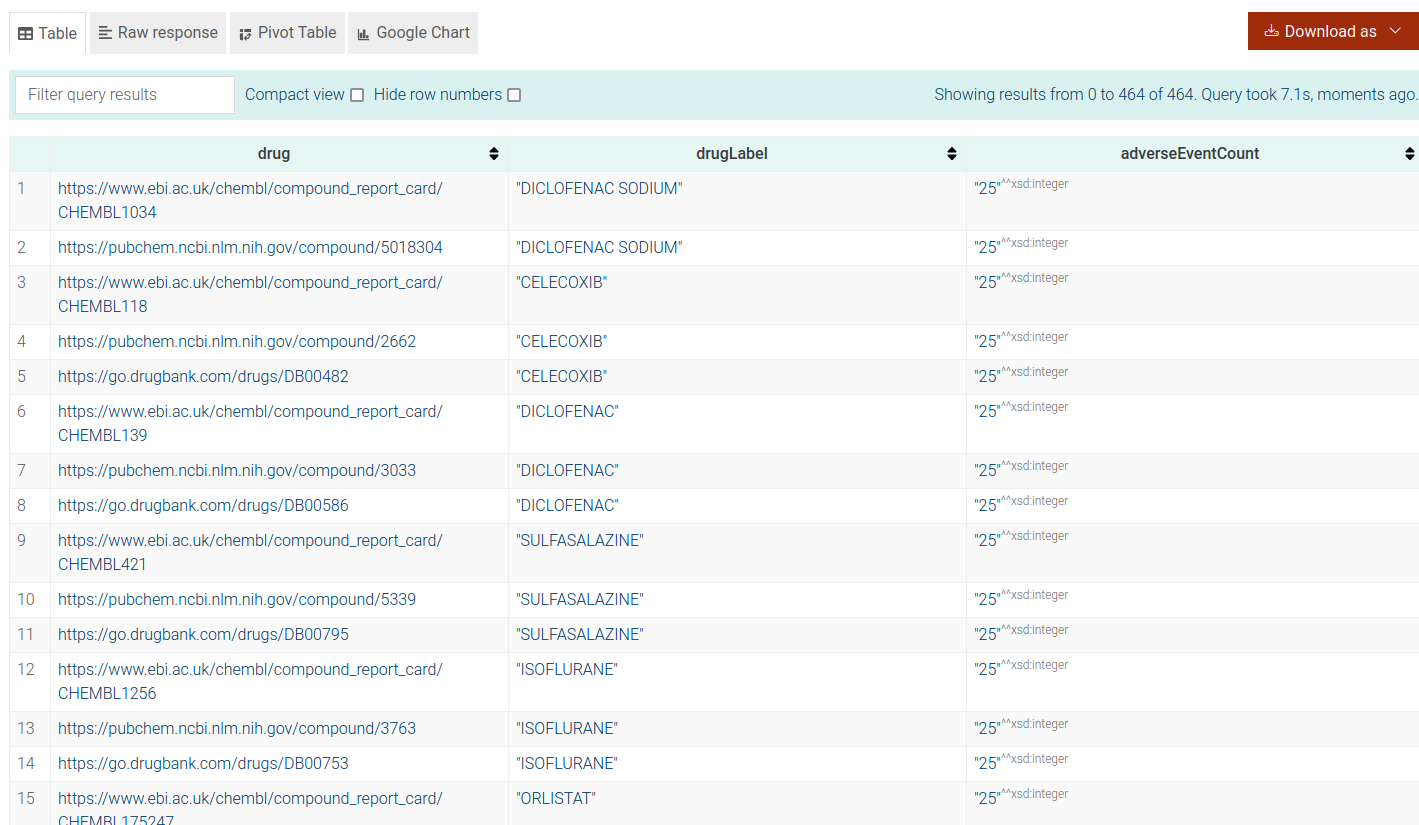